In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from matplotlib import pyplot as plt
import math

In [2]:
all_data = []
image_chop = 25

for i in range(0,7):
    pkl_file = open(f'../data/cat{i}.pkl', 'rb')
    data = pickle.load(pkl_file)
    data = data.reshape(int(data.shape[0] * image_chop), int(data.shape[1] / image_chop), 3)
    print(data.shape)
    pkl_file.close()
    all_data.append(data)

(41875, 3600, 3)
(40000, 3600, 3)
(43175, 3600, 3)
(19850, 3600, 3)
(34300, 3600, 3)
(32575, 3600, 3)
(34050, 3600, 3)


In [3]:
print(len(all_data))
samples = 0
for i in range(0,7):
    print(all_data[i].shape)
    samples += all_data[i].shape[0]
print(f'Sample size: {samples}')

7
(41875, 3600, 3)
(40000, 3600, 3)
(43175, 3600, 3)
(19850, 3600, 3)
(34300, 3600, 3)
(32575, 3600, 3)
(34050, 3600, 3)
Sample size: 245825


In [4]:
device = torch.device('cuda:0')

In [19]:
# params
D_in = all_data[1].shape[1]
H1 = 2700
H2 = 1800
D_out = 900

learning_rate = 0.001
batch_size = image_chop
epochs = 100

# Regularisierung
weight_decay=0.001

In [22]:
# Neural Network
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out)
        )

        self.decoder = torch.nn.Sequential(
            nn.Linear(D_out, H2),
            nn.ReLU(),
            nn.Linear(H2, H1),
            nn.ReLU(),
            nn.Linear(H1, D_in),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
model = autoencoder()
model.cuda()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3600, out_features=2700, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2700, out_features=1800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1800, out_features=900, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=900, out_features=1800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1800, out_features=2700, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2700, out_features=3600, bias=True)
    (5): Sigmoid()
  )
)

In [24]:
class PSNR(nn.Module):

    def __init__(self):
        super(PSNR, self).__init__()
        
    def forward(self, input, target):
        return Variable(torch.tensor(10 * math.log10((torch.max(target) * torch.max(target)) / F.mse_loss(input, target))), requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = PSNR()

In [25]:
# Train
loss_hist = []

for t in range(epochs):
    for bulk in range(len(all_data)):
        x = torch.tensor(all_data[bulk], dtype=torch.float32, device=device)
        for batch in range(0, int(x.shape[0]/batch_size)):
            
            # Berechne den Batch
            batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 2)
        
            # Berechne die Vorhersage (foward step)
            outputs = model.forward(batch_x)

            # Berechne den Fehler
            loss = criterion(outputs, batch_x)
        
            # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    # Berechne den Fehler (Ausgabe des Fehlers alle x Iterationen)
    if t % 2 == 0:
        loss_hist.append(loss.item())
        print(t, f"PSNR: {loss.item()}")

0 PSNR: 13.427236557006836
2 PSNR: 13.427236557006836
4 PSNR: 13.427236557006836
6 PSNR: 13.427236557006836
8 PSNR: 13.427236557006836


KeyboardInterrupt: 

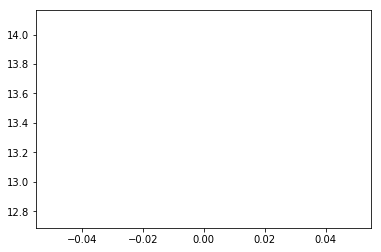

In [17]:
plt.plot(loss_hist)

In [18]:
torch.save(model.cpu(), '../data/models/ae_x2_psnr.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
